In [68]:
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
#CSVデータの読み込み

In [69]:
df_data = pd.read_csv("C:/Users/sst160312/skillupai/DAY1_vr3_0_0/ks-projects-201801.csv")

In [70]:
df_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [7]:
# ID,nameは固有値なので予測には必要なし。
# pledged・backersは実運用をしようとした際に未知の値となるため予測データとしては使用できない。(usd pledgedも同様)
# currency と countryは意味合いが同じであるためどちらかのみ使用する。
# usd pledged,usd_pledged_real,usd_goal_realはKaggleサイトより予測には使用しないことが書いてある。
# (恐らくusd pledged はpledgedのusドル変換したもの。usd_pledged_realはpledgedと数値が同値であるため、意味合いも似たようなもの？usd_goal_realは実際のgoalのusドル？）


In [71]:
#以上の説明変数をまずは除去する
df_data_col=['ID','name','pledged','backers','country','usd pledged','usd_pledged_real','usd_goal_real']
df_data = df_data.drop(df_data_col,axis=1)

In [72]:
#目的変数stateが成功失敗の2値にする
print(len(df_data))
df_data = df_data[df_data.state.str.contains("canceled") == False]
df_data = df_data[df_data.state.str.contains("live") == False]
df_data = df_data[df_data.state.str.contains("suspended") == False]
df_data = df_data[df_data.state.str.contains("undefined") == False]
print(len(df_data))

378661
331675


In [12]:
# stateを成功失敗の2値だけを残したが、大きくデータ数は減少していないので先に進む

In [73]:
#欠損値の確認
df_data.isnull().sum()

category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
state            0
dtype: int64

In [74]:
#欠損値は特に問題なし
#日付はこのままでは使えないので開始終了で日付の差分をとる
df_data['deadline'] = pd.to_datetime(df_data['deadline'])
df_data['launched'] = pd.to_datetime(pd.to_datetime(df_data['launched']).dt.strftime('%Y-%m-%d'))
df_data['datenum'] = (df_data['deadline']-df_data['launched']).astype('timedelta64[D]')

In [75]:
#目的変数がまだ文字列のままなので数値変換する
df_data.loc[df_data['state'] == 'successful', 'state_flg'] = 1
df_data.loc[df_data['state'] != 'successful', 'state_flg'] = 0

In [76]:
#deadlineとlaunchedは差分(datenum)を利用するため変数項目から除く
df_data_col=['deadline','launched']
df_data = df_data.drop(df_data_col,axis=1)

In [77]:
# 同様にstateも数値返還後のstate_flgを目的変数として利用するためstateは項目から除く
df_data = df_data.drop('state',axis=1)

In [20]:
df_data.head()

,category,main_category,currency,goal,datenum,state_flg
0,Poetry,Publishing,GBP,1000.0,59.0,0.0
1,Narrative Film,Film & Video,USD,30000.0,60.0,0.0
2,Narrative Film,Film & Video,USD,45000.0,45.0,0.0
3,Music,Music,USD,5000.0,30.0,0.0
5,Restaurants,Food,USD,50000.0,35.0,1.0


In [22]:
#カテゴリ数を確認する
df_data.select_dtypes('object').apply(pd.Series.nunique,axis=0)

category         159
main_category     15
currency          14
dtype: int64

In [78]:
#categoryは値の種類が多く、one-hot-encordingすると変数が多くなりすぎるため今回は使用せずに予測してみる。（余力があればcategoryも使ってみる）
#main_categoryとcurrencyはone-hot-encordingする
df_data = df_data.drop('category',axis=1)
df_data = pd.get_dummies(df_data, columns=['main_category','currency'])
df_data.head()

,goal,datenum,state_flg,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,1000.0,59.0,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,30000.0,60.0,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,45000.0,45.0,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,5000.0,30.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,50000.0,35.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


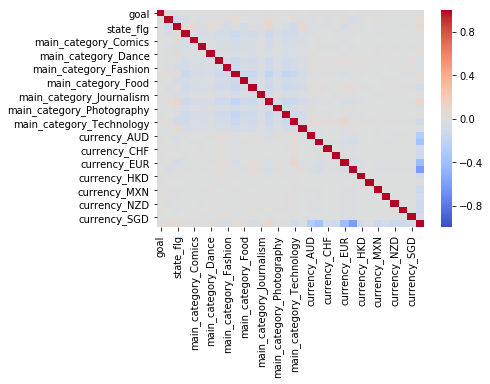

In [79]:
# 説明変数間の相関係数をヒートマップにして可視化
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df_data.corr(),cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [25]:
# 相関係数を確認
df_data.corr()

,goal,datenum,state_flg,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
goal,1.000000,0.022692,-0.025099,-0.000864,-0.003662,-0.004621,-0.003291,-0.000461,-0.004483,0.013758,...,0.003710,-0.005173,0.004898,0.010552,0.013077,0.012088,-0.000711,0.016739,-0.000783,-0.008478
datenum,0.022692,1.000000,-0.116437,-0.036935,-0.001492,-0.030644,-0.009370,0.004162,-0.026566,0.037583,...,0.012848,-0.054041,0.000385,-0.003416,0.013080,0.002672,-0.012681,-0.003603,-0.005289,0.035064
state_flg,-0.025099,-0.116437,1.000000,0.026554,0.066964,-0.042224,0.053270,0.007077,-0.062116,0.012959,...,-0.058082,0.003807,0.003786,-0.001689,-0.016415,-0.010679,-0.006610,-0.009206,-0.000891,0.056581
main_category_Art,-0.000864,-0.036935,0.026554,1.000000,-0.050714,-0.044973,-0.030206,-0.083293,-0.072884,-0.131198,...,-0.010340,0.005803,-0.001750,-0.001055,0.005016,-0.003809,-0.003192,-0.001968,-0.004610,0.006419
main_category_Comics,-0.003662,-0.001492,0.066964,-0.050714,1.000000,-0.027222,-0.018283,-0.050416,-0.044116,-0.079412,...,-0.021357,-0.005850,-0.004309,-0.001459,-0.003821,-0.000589,-0.006578,-0.005262,-0.003128,0.016097
main_category_Crafts,-0.004621,-0.030644,-0.042224,-0.044973,-0.027222,1.000000,-0.016214,-0.044709,-0.039122,-0.070423,...,-0.001260,0.006929,-0.000652,-0.001294,0.007249,-0.000363,0.001597,-0.000765,0.007148,-0.009788
main_category_Dance,-0.003291,-0.009370,0.053270,-0.030206,-0.018283,-0.016214,1.000000,-0.030029,-0.026276,-0.047300,...,-0.012318,-0.005495,-0.003190,-0.000869,0.002603,-0.001596,-0.002703,-0.004454,-0.003074,0.018869
main_category_Design,-0.000461,0.004162,0.007077,-0.083293,-0.050416,-0.044709,-0.030029,1.000000,-0.072457,-0.130428,...,0.033175,0.001670,0.042069,0.003053,-0.005212,0.000633,0.006158,0.004639,0.025555,-0.042041
main_category_Fashion,-0.004483,-0.026566,-0.062116,-0.072884,-0.044116,-0.039122,-0.026276,-0.072457,1.000000,-0.114129,...,0.020744,0.012198,0.003548,0.008607,-0.005503,-0.000249,0.002890,0.000940,0.022018,-0.032915
main_category_Film & Video,0.013758,0.037583,0.012959,-0.131198,-0.079412,-0.070423,-0.047300,-0.130428,-0.114129,1.000000,...,-0.049275,0.005507,-0.015297,-0.003775,0.002405,-0.007178,-0.005331,-0.008856,-0.013528,0.046747


In [82]:
#currency_USDはcurrency_GBPとの相関はやや強いが-0.6なのですごく強いわけでもないのでいったん残しておく
#RaddomForest

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = df_data["state_flg"].values
X = df_data.drop("state_flg", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=10, max_depth=8, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X_test, y_test)
print("score=", clf.score(X_test, y_test))

score= 0.6501997437250321


In [90]:
train_x =  df_data.drop("state_flg", axis=1)
importance = pd.DataFrame({ '変数' :train_x.columns, '重要度' :clf.feature_importances_})
importance

,変数,重要度
0,goal,0.319783
1,datenum,0.235189
2,main_category_Art,0.001475
3,main_category_Comics,0.036133
4,main_category_Crafts,0.007757
5,main_category_Dance,0.022435
6,main_category_Design,0.002773
7,main_category_Fashion,0.037433
8,main_category_Film & Video,0.000003
9,main_category_Food,0.036417


In [91]:
#main_categoryおよびcurrencyは１つは変数削除する必要があるため、上記より重要度の低い変数を除く
df_data_col=['main_category_Film & Video','currency_CHF','currency_JPY','currency_NZD','currency_NOK','currency_SGD']
df_data = df_data.drop(df_data_col,axis=1)

In [92]:
#再度RandmoForest

In [93]:
y = df_data["state_flg"].values
X = df_data.drop("state_flg", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=10, max_depth=8, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X_test, y_test)
print("score=", clf.score(X_test, y_test))

score= 0.6511193186100852


In [94]:
#木の数を増やして再度これが適用できそうか確認する

In [95]:
y = df_data["state_flg"].values
X = df_data.drop("state_flg", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100, max_depth=8, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X_test, y_test)
print("score=", clf.score(X_test, y_test))

score= 0.6539986432501695


In [96]:
#木の数を増やすことによって多少であるがスコアは上がった
#この状態で再度変数の重要度を確認する

In [97]:
train_x =  df_data.drop("state_flg", axis=1)
importance = pd.DataFrame({ '変数' :train_x.columns, '重要度' :clf.feature_importances_})
importance

,変数,重要度
0,goal,0.447231
1,datenum,0.200629
2,main_category_Art,0.002147
3,main_category_Comics,0.022459
4,main_category_Crafts,0.011524
5,main_category_Dance,0.012895
6,main_category_Design,0.003492
7,main_category_Fashion,0.028299
8,main_category_Food,0.023772
9,main_category_Games,0.005104


In [98]:
#一番重要度の高いgoalとの差が大きすぎるものを除去しさらに、変数を減らす
df_data_col=['currency_SEK','currency_MXN','currency_HKD','currency_DKK','currency_CAD','currency_AUD']
df_data = df_data.drop(df_data_col,axis=1)

In [99]:
#再度RandomForest

y = df_data["state_flg"].values
X = df_data.drop("state_flg", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=200, max_depth=8, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X_test, y_test)
print("score=", clf.score(X_test, y_test))

score= 0.6550840431144946


In [100]:
#変数を減らしてもscoreは大きく変化しないので、これ以上変数を減らしてもあまり効果はなさそう

In [102]:
#調べると、min_samples_leafはデフォルト１、min_samples_splitはデフォルトなしなので、これに変換して再度実行

In [104]:
y = df_data["state_flg"].values
X = df_data.drop("state_flg", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100, max_depth=8, criterion="gini", min_samples_leaf=1, random_state=1234)
clf.fit(X_test, y_test)
print("score=", clf.score(X_test, y_test))

score= 0.6538328182708977


In [105]:
#score変化なし。。。
#max_depthを動かしてみる

In [106]:
y = df_data["state_flg"].values
X = df_data.drop("state_flg", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100, max_depth=5, criterion="gini", min_samples_leaf=1, random_state=1234)
clf.fit(X_test, y_test)
print("score=", clf.score(X_test, y_test))

score= 0.6412904198386975


In [107]:
y = df_data["state_flg"].values
X = df_data.drop("state_flg", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100, max_depth=11, criterion="gini", min_samples_leaf=1, random_state=1234)
clf.fit(X_test, y_test)
print("score=", clf.score(X_test, y_test))

score= 0.6713047410869074


In [108]:
clf = RandomForestClassifier(n_estimators=100, max_depth=12, criterion="gini", min_samples_leaf=1, random_state=1234)
clf.fit(X_test, y_test)
print("score=", clf.score(X_test, y_test))

score= 0.6819627647546544


In [114]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Precision, Recall, F1-scoreを計算
y_test_pred = clf.predict(X_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)

# \Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

適合率（Precision） = 68.515%
再現率（Recall） = 86.510%
F1値（F1-score） = 76.468%


In [115]:
#クラウドファンディングは適合率が高いほうがいいと思うが、適合率・再現率ともにそれなりに高い数値がでているのではないか。
#max_depthを動かしてscoreしか見ていなかったので念のため他のmax_depthの適合率も確認する

In [116]:
clf = RandomForestClassifier(n_estimators=100, max_depth=11, criterion="gini", min_samples_leaf=1, random_state=1234)
clf.fit(X_test, y_test)
print("score=", clf.score(X_test, y_test))

# Precision, Recall, F1-scoreを計算
y_test_pred = clf.predict(X_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)

# \Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

score= 0.6713047410869074
適合率（Precision） = 67.387%
再現率（Recall） = 87.146%
F1値（F1-score） = 76.004%


In [117]:
clf = RandomForestClassifier(n_estimators=100, max_depth=8, criterion="gini", min_samples_leaf=1, random_state=1234)
clf.fit(X_test, y_test)

# Precision, Recall, F1-scoreを計算
y_test_pred = clf.predict(X_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)

# \Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

適合率（Precision） = 65.900%
再現率（Recall） = 87.139%
F1値（F1-score） = 75.046%


In [118]:
#scoreが下がれば適合率・再現率・F1値もさがる
#なら、max_depthをさらに大きくしてみる

clf = RandomForestClassifier(n_estimators=100, max_depth=15, criterion="gini", min_samples_leaf=1, random_state=1234)
clf.fit(X_test, y_test)

# Precision, Recall, F1-scoreを計算
y_test_pred = clf.predict(X_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)

# \Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

適合率（Precision） = 71.961%
再現率（Recall） = 85.937%
F1値（F1-score） = 78.330%


In [121]:
#max_depthはデフォルトなしでもできるみたい

clf = RandomForestClassifier(n_estimators=100, criterion="gini", min_samples_leaf=1, random_state=1234)
clf.fit(X_test, y_test)

# Precision, Recall, F1-scoreを計算
y_test_pred = clf.predict(X_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

適合率（Precision） = 80.373%
再現率（Recall） = 88.913%
F1値（F1-score） = 84.428%


In [143]:
#----------------------------------------------------------
#カテゴリ変数の変換をTarget Mean Encodingでもやってみる

In [126]:
df_data2 = pd.read_csv("C:/Users/sst160312/skillupai/DAY1_vr3_0_0/ks-projects-201801.csv")

In [128]:
df_data2_col=['ID','name','pledged','backers','country','usd pledged','usd_pledged_real','usd_goal_real']
df_data2 = df_data2.drop(df_data2_col,axis=1)

In [131]:
#目的変数stateが成功失敗の2値にする
print(len(df_data2))
df_data2 = df_data2[df_data2.state.str.contains("canceled") == False]#日付変換
df_data2['deadline'] = pd.to_datetime(df_data2['deadline'])
df_data2['launched'] = pd.to_datetime(pd.to_datetime(df_data2['launched']).dt.strftime('%Y-%m-%d'))
df_data2['datenum'] = (df_data2['deadline']-df_data2['launched']).astype('timedelta64[D]')
df_data2 = df_data2[df_data2.state.str.contains("live") == False]
df_data2 = df_data2[df_data2.state.str.contains("suspended") == False]
df_data2 = df_data2[df_data2.state.str.contains("undefined") == False]
print(len(df_data2))

378661
331675


In [132]:
#日付変換
df_data2['deadline'] = pd.to_datetime(df_data2['deadline'])
df_data2['launched'] = pd.to_datetime(pd.to_datetime(df_data2['launched']).dt.strftime('%Y-%m-%d'))
df_data2['datenum'] = (df_data2['deadline']-df_data2['launched']).astype('timedelta64[D]')

In [133]:
df_data2.loc[df_data2['state'] == 'successful', 'state_flg'] = 1
df_data2.loc[df_data2['state'] != 'successful', 'state_flg'] = 0

In [134]:
df_data_col=['deadline','launched','state']
df_data2 = df_data2.drop(df_data_col,axis=1)

In [135]:
df_data2.head()

,category,main_category,currency,goal,datenum,state_flg
0,Poetry,Publishing,GBP,1000.0,59.0,0.0
1,Narrative Film,Film & Video,USD,30000.0,60.0,0.0
2,Narrative Film,Film & Video,USD,45000.0,45.0,0.0
3,Music,Music,USD,5000.0,30.0,0.0
5,Restaurants,Food,USD,50000.0,35.0,1.0


In [139]:
df_data2 = df_data2.assign(target_enc=df_data2.groupby('category')['state_flg'].transform('mean').copy())

In [140]:
df_data2 = df_data2.assign(target_enc_main_category=df_data2.groupby('main_category')['state_flg'].transform('mean').copy())
df_data2 = df_data2.assign(target_enc_currency=df_data2.groupby('currency')['state_flg'].transform('mean').copy())

In [141]:
df_data2.head()

,category,main_category,currency,goal,datenum,state_flg,target_enc,target_enc_main_category,target_enc_currency
0,Poetry,Publishing,GBP,1000.0,59.0,0.0,0.390851,0.347017,0.409859
1,Narrative Film,Film & Video,USD,30000.0,60.0,0.0,0.435903,0.417906,0.418258
2,Narrative Film,Film & Video,USD,45000.0,45.0,0.0,0.435903,0.417906,0.418258
3,Music,Music,USD,5000.0,30.0,0.0,0.509143,0.526606,0.418258
5,Restaurants,Food,USD,50000.0,35.0,1.0,0.181421,0.275914,0.418258


In [144]:
df_data_col=['category','main_category','currency']
df_data2 = df_data2.drop(df_data_col,axis=1)

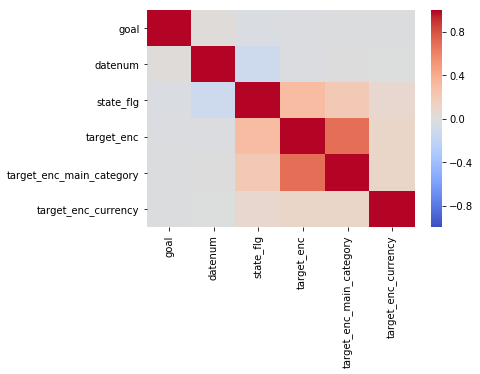

In [145]:
sns.heatmap(df_data2.corr(),cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [146]:
#カテゴリとメインカテゴリーの相関は正の相関が強いのでどちらかを除く

In [147]:
y = df_data2["state_flg"].values
X = df_data2.drop("state_flg", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100, criterion="gini",min_samples_leaf=1, random_state=1234)
clf.fit(X_test, y_test)

train_x =  df_data2.drop("state_flg", axis=1)
importance = pd.DataFrame({ '変数' :train_x.columns, '重要度' :clf.feature_importances_})
importance

,変数,重要度
0,goal,0.409006
1,datenum,0.234098
2,target_enc,0.218126
3,target_enc_main_category,0.073728
4,target_enc_currency,0.065041


In [148]:
#main_category < category なので、多重共線性よりmain_categoryを変数から除く

In [149]:
df_data2 = df_data2.drop('target_enc_main_category',axis=1)

In [150]:
y = df_data2["state_flg"].values
X = df_data2.drop("state_flg", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100, criterion="gini",min_samples_leaf=1, random_state=1234)
clf.fit(X_test, y_test)

# Precision, Recall, F1-scoreを計算
y_test_pred = clf.predict(X_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

適合率（Precision） = 88.350%
再現率（Recall） = 92.190%
F1値（F1-score） = 90.229%


In [151]:
## カテゴリ変数の変換をTarget Mean Encodingでもやってみたほうが、精度はあがった
## ただし、使用している説明変数が main_categoryをone-hot-encordingしたのに対し、Target Mean Encodingでは多重共線性を踏まえcategoryの方を採用したので比較が難しい
## main_categoryではなく、categoryをone-hot-encordingしたらどうなるのか検証してみる

In [152]:
df_data3 = pd.read_csv("C:/Users/sst160312/skillupai/DAY1_vr3_0_0/ks-projects-201801.csv")

In [153]:
#目的変数stateが成功失敗の2値にする
print(len(df_data3))
df_data3 = df_data3[df_data3.state.str.contains("canceled") == False]
df_data3 = df_data3[df_data3.state.str.contains("live") == False]
df_data3 = df_data3[df_data3.state.str.contains("suspended") == False]
df_data3 = df_data3[df_data3.state.str.contains("undefined") == False]
print(len(df_data3))

378661
331675


In [154]:
#日付変換
df_data3['deadline'] = pd.to_datetime(df_data3['deadline'])
df_data3['launched'] = pd.to_datetime(pd.to_datetime(df_data3['launched']).dt.strftime('%Y-%m-%d'))
df_data3['datenum'] = (df_data3['deadline']-df_data3['launched']).astype('timedelta64[D]')

df_data3.loc[df_data3['state'] == 'successful', 'state_flg'] = 1
df_data3.loc[df_data3['state'] != 'successful', 'state_flg'] = 0

In [155]:
df_data3.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,datenum,state_flg
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,0.0,0.0,1533.95,59.0,0.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,100.0,2421.0,30000.00,60.0,0.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,220.0,220.0,45000.00,45.0,0.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,1.0,1.0,5000.00,30.0,0.0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26,52375.0,successful,224,US,52375.0,52375.0,50000.00,35.0,1.0


In [156]:
df_data3_col=['ID','name','pledged','backers','country','usd pledged','usd_pledged_real','usd_goal_real','main_category','deadline','launched','state']
df_data3 = df_data3.drop(df_data3_col,axis=1)

In [157]:
df_data3.head()

,category,currency,goal,datenum,state_flg
0,Poetry,GBP,1000.0,59.0,0.0
1,Narrative Film,USD,30000.0,60.0,0.0
2,Narrative Film,USD,45000.0,45.0,0.0
3,Music,USD,5000.0,30.0,0.0
5,Restaurants,USD,50000.0,35.0,1.0


In [158]:
df_data3 = pd.get_dummies(df_data3, columns=['category','currency'])
df_data3.head()

,goal,datenum,state_flg,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,1000.0,59.0,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,30000.0,60.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,45000.0,45.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5000.0,30.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,50000.0,35.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


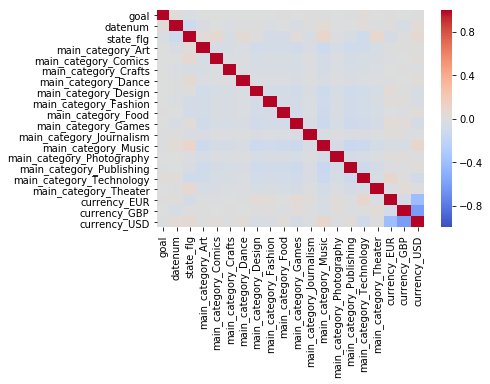

In [159]:
sns.heatmap(df_data.corr(),cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [160]:
y = df_data3["state_flg"].values
X = df_data3.drop("state_flg", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100, criterion="gini",min_samples_leaf=1, random_state=1234)
clf.fit(X_test, y_test)

train_x =  df_data3.drop("state_flg", axis=1)
importance = pd.DataFrame({ '変数' :train_x.columns, '重要度' :clf.feature_importances_})
importance

,変数,重要度
0,goal,0.428963
1,datenum,0.214333
2,category_3D Printing,0.001480
3,category_Academic,0.001290
4,category_Accessories,0.003285
5,category_Action,0.000995
6,category_Animals,0.000540
7,category_Animation,0.002393
8,category_Anthologies,0.001930
9,category_Apparel,0.005236


In [161]:
#ategoryおよびcurrencyは１つは変数削除する必要があるため、上記より重要度の低い変数を除く
df_data_col=['currency_JPY','currency_HKD','currency_CHF','category_Zines','category_Workshops','category_Weaving','category_Video Art','category_Video','category_Typography','category_Translations','category_Civic Design','category_Chiptune','category_Childrenswear','category_Ceramics','category_Candles','category_Camera Equipment','category_Calendars','category_Blues','category_Bacon','category_Audio','category_Action']
df_data3 = df_data3.drop(df_data_col,axis=1)

In [162]:
y = df_data3["state_flg"].values
X = df_data3.drop("state_flg", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100, criterion="gini",min_samples_leaf=1, random_state=1234)
clf.fit(X_test, y_test)

train_x =  df_data3.drop("state_flg", axis=1)
importance = pd.DataFrame({ '変数' :train_x.columns, '重要度' :clf.feature_importances_})
importance

,変数,重要度
0,goal,0.428601
1,datenum,0.224206
2,category_3D Printing,0.001305
3,category_Academic,0.001198
4,category_Accessories,0.003397
5,category_Animals,0.000558
6,category_Animation,0.002676
7,category_Anthologies,0.001960
8,category_Apparel,0.004427
9,category_Apps,0.007088


In [165]:
pd.set_option('display.max_rows', 154)

In [167]:
importance

,変数,重要度
0,goal,0.428601
1,datenum,0.224206
2,category_3D Printing,0.001305
3,category_Academic,0.001198
4,category_Accessories,0.003397
5,category_Animals,0.000558
6,category_Animation,0.002676
7,category_Anthologies,0.001960
8,category_Apparel,0.004427
9,category_Apps,0.007088


In [169]:
df_data_col=['category_Animals','category_Community Gardens','category_Cookbooks','category_Couture','category_Crochet','category_Embroidery','category_Fabrication Tools','category_Family','category_Fantasy','category_Fantasy','category_Farmer\'s Markets','category_Flight','category_Gaming Hardware','category_Glass','category_Immersive','category_Installations','category_Interactive Design','category_Kids','category_Knitting','category_Latin','category_Letterpress','category_Literary Journals','category_Literary Spaces','category_Makerspaces','category_Movie Theaters','category_Pet Fashion','category_Photo','category_Pottery','category_Printing','category_Quilts','category_R&B','category_Residencies','category_Romance','category_Space Exploration','category_Taxidermy','category_Textiles']
df_data3 = df_data3.drop(df_data_col,axis=1)

In [170]:
y = df_data3["state_flg"].values
X = df_data3.drop("state_flg", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100, criterion="gini",min_samples_leaf=1, random_state=1234)
clf.fit(X_test, y_test)

# Precision, Recall, F1-scoreを計算
y_test_pred = clf.predict(X_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

適合率（Precision） = 87.104%
再現率（Recall） = 92.458%
F1値（F1-score） = 89.701%


In [172]:
#まとめ
#category と main_categoryの相関が強いため説明変数としてはどちらかしか使えない

#main_categoryをone-hot-encordingし、RandomForestした場合
#適合率（Precision） = 80.373%
#再現率（Recall） = 88.913%
#F1値（F1-score） = 84.428%

#categoryをtarget mean encordingし、RandomForestした場合
#適合率（Precision） = 88.350%
#再現率（Recall） = 92.190%
#F1値（F1-score） = 90.229%

#categoryをone-hot-encordingし、RandomForestした場合
#適合率（Precision） = 87.104%
#再現率（Recall） = 92.458%
#F1値（F1-score） = 89.701%

#以上より、カテゴリの種類はmain_categoryの方が少なく、one-hot-encordingしても説明変数が増えすぎるという事象は発生しない。
#categoryの方が詳細レベルの情報を持っているため予測精度をあげるにはcategoryを説明変数として利用するのが良いと考えられる
#target mean encording とone-hot-encordingに大きな差は見られなかった